In [1]:
import pandas as pd 
import numpy as np
import talib as ta
import yfinance as yf
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [2]:
stocks=['HDFCBANK.NS','TATAMOTORS.NS','ITC.NS','ULTRACEMCO.NS','CIPLA.NS', 'TITAN.NS']

In [3]:
df=yf.download(stocks,start='2015-04-01',end='2017-03-31',progress=False)['Adj Close']
df.head()

,CIPLA.NS,HDFCBANK.NS,ITC.NS,TATAMOTORS.NS,TITAN.NS,ULTRACEMCO.NS
Date,,,,,,
2015-04-01,689.644409,489.981445,176.924286,558.678955,374.593536,2822.559814
2015-04-06,714.961792,489.364929,181.474442,567.920044,387.259125,2831.222168
2015-04-07,707.721375,489.744293,181.261581,560.123108,390.137695,2869.688721
2015-04-08,715.982361,491.072174,184.268417,561.272705,390.953247,2923.131104
2015-04-09,699.217346,500.817200,184.747391,559.673340,383.756927,2901.107910


In [4]:
test=yf.download(stocks,start='2017-04-01',end='2018-03-31',progress=False)['Adj Close']
test.head()

,CIPLA.NS,HDFCBANK.NS,ITC.NS,TATAMOTORS.NS,TITAN.NS,ULTRACEMCO.NS
Date,,,,,,
2017-04-03,579.595398,690.371887,230.533997,470.399994,446.533630,3963.961670
2017-04-05,579.986511,689.962402,228.405151,473.500000,478.029633,4017.611816
2017-04-06,577.297058,692.924866,224.433945,473.200012,473.800995,4047.045166
2017-04-07,577.003662,693.093445,223.246643,468.299988,471.856781,4017.365479
2017-04-10,576.661438,690.829590,223.983582,474.899994,472.197021,3995.610107


### Covariance Matrix

In [5]:
cov_matrix = df.pct_change().apply(lambda x: np.log(1+x)).cov()
cov_matrix

,CIPLA.NS,HDFCBANK.NS,ITC.NS,TATAMOTORS.NS,TITAN.NS,ULTRACEMCO.NS
CIPLA.NS,0.000261,0.000061,0.000066,0.000082,0.000066,0.000086
HDFCBANK.NS,0.000061,0.000104,0.000058,0.000089,0.000049,0.000075
ITC.NS,0.000066,0.000058,0.000247,0.000109,0.000060,0.000072
TATAMOTORS.NS,0.000082,0.000089,0.000109,0.000598,0.000134,0.000166
TITAN.NS,0.000066,0.000049,0.000060,0.000134,0.000346,0.000089
ULTRACEMCO.NS,0.000086,0.000075,0.000072,0.000166,0.000089,0.000272


### Correlation Matrix

In [6]:
corr_matrix = df.pct_change().apply(lambda x: np.log(1+x)).corr()
corr_matrix

,CIPLA.NS,HDFCBANK.NS,ITC.NS,TATAMOTORS.NS,TITAN.NS,ULTRACEMCO.NS
CIPLA.NS,1.000000,0.372773,0.261593,0.207044,0.219821,0.322065
HDFCBANK.NS,0.372773,1.000000,0.359675,0.357669,0.256978,0.448888
ITC.NS,0.261593,0.359675,1.000000,0.283426,0.204383,0.279907
TATAMOTORS.NS,0.207044,0.357669,0.283426,1.000000,0.293691,0.412066
TITAN.NS,0.219821,0.256978,0.204383,0.293691,1.000000,0.289499
ULTRACEMCO.NS,0.322065,0.448888,0.279907,0.412066,0.289499,1.000000


In [7]:
exp_returns=df.resample('Y').last().pct_change().mean()
exp_returns

CIPLA.NS        -0.034804
HDFCBANK.NS      0.169667
ITC.NS           0.141026
TATAMOTORS.NS    0.099549
TITAN.NS         0.173400
ULTRACEMCO.NS    0.199649
dtype: float64

In [8]:
volatility = df.pct_change().apply(lambda x: np.log(1+x)).std().apply(lambda x: x*np.sqrt(250))
volatility

CIPLA.NS         0.255312
HDFCBANK.NS      0.161132
ITC.NS           0.248294
TATAMOTORS.NS    0.386727
TITAN.NS         0.294162
ULTRACEMCO.NS    0.260531
dtype: float64

In [9]:
assets = pd.concat([exp_returns, volatility], axis=1) # Creating a table for visualising returns and volatility of assets
assets.columns = ['Returns', 'Volatility']
assets

,Returns,Volatility
CIPLA.NS,-0.034804,0.255312
HDFCBANK.NS,0.169667,0.161132
ITC.NS,0.141026,0.248294
TATAMOTORS.NS,0.099549,0.386727
TITAN.NS,0.173400,0.294162
ULTRACEMCO.NS,0.199649,0.260531


### Portfolio weights by Monte Carlo

In [10]:
num_portfolios = 50000
results = np.zeros((2+len(stocks),num_portfolios))

In [11]:
for i in range(num_portfolios):
    
    weights = np.array(np.random.random(6))
    weights /= np.sum(weights)
    
    #calculate portfolio return and volatility
    portfolio_return = np.sum(exp_returns * weights)
    var = cov_matrix.mul(weights, axis=0).mul(weights, axis=1).sum().sum()# Portfolio Variance
    sd = np.sqrt(var) # Daily standard deviation
    ann_sd = sd*np.sqrt(250) # Annual standard deviation = volatility
    
    #store results in results array
    results[0,i] = portfolio_return
    results[1,i]= ann_sd
    
    #iterate through the weight vector and add data to results array
    for j in range(len(weights)):
        results[j+2,i] = weights[j]


In [12]:
#convert results array to Pandas DataFrame
weights = pd.DataFrame(results.T,columns=['Returns','Volatility',stocks[0]+' weight',stocks[1]+' weight',stocks[2]+' weight',
                                          stocks[3]+' weight',stocks[4]+' weight',stocks[5]+' weight'])
weights.head()

,Returns,Volatility,HDFCBANK.NS weight,TATAMOTORS.NS weight,ITC.NS weight,ULTRACEMCO.NS weight,CIPLA.NS weight,TITAN.NS weight
0,0.114317,0.190578,0.198125,0.080904,0.113817,0.233028,0.245965,0.128161
1,0.151277,0.170918,0.128829,0.337562,0.042580,0.041552,0.053003,0.396476
2,0.150643,0.170587,0.078186,0.364935,0.057641,0.142546,0.079433,0.277258
3,0.111781,0.175714,0.199661,0.336176,0.102767,0.236456,0.048907,0.076033
4,0.112221,0.192395,0.202912,0.058509,0.199612,0.246531,0.065534,0.226903


In [13]:
min_vol_point = weights.iloc[weights['Volatility'].idxmin()]
min_vol_point

Returns                 0.129455
Volatility              0.147982
HDFCBANK.NS weight      0.172030
TATAMOTORS.NS weight    0.520780
ITC.NS weight           0.197299
ULTRACEMCO.NS weight    0.003387
CIPLA.NS weight         0.089214
TITAN.NS weight         0.017290
Name: 39226, dtype: float64

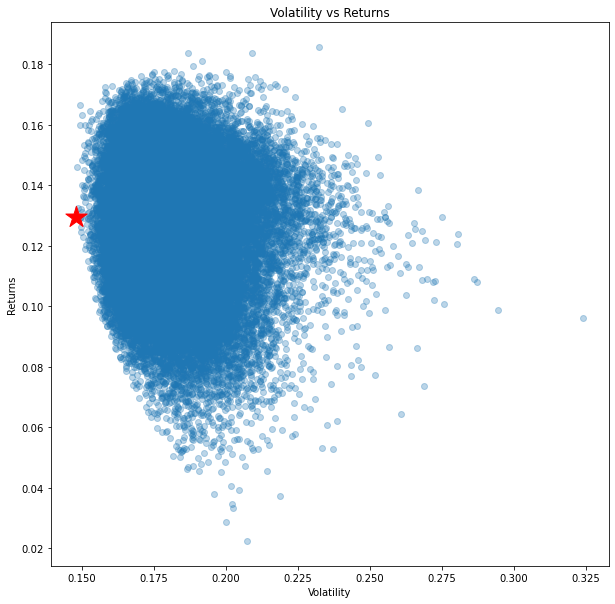

In [14]:
fig, ax = plt.subplots(figsize=(10, 10))
plt.scatter(data=weights, x='Volatility', y='Returns', marker='o',alpha=0.3)
plt.scatter(min_vol_point[1],min_vol_point[0], color='r', marker='*', s=500)
ax.set_title(f"Volatility vs Returns")
ax.set_xlabel(f"Volatility")
ax.set_ylabel(f"Returns")
fig.show()

### Maximium Sharpe Ratio

In [15]:
sharpe_ratio= weights['Returns']/weights['Volatility']
weights['Sharpe Ratio']=sharpe_ratio
weights.head()

,Returns,Volatility,HDFCBANK.NS weight,TATAMOTORS.NS weight,ITC.NS weight,ULTRACEMCO.NS weight,CIPLA.NS weight,TITAN.NS weight,Sharpe Ratio
0,0.114317,0.190578,0.198125,0.080904,0.113817,0.233028,0.245965,0.128161,0.599846
1,0.151277,0.170918,0.128829,0.337562,0.042580,0.041552,0.053003,0.396476,0.885085
2,0.150643,0.170587,0.078186,0.364935,0.057641,0.142546,0.079433,0.277258,0.883088
3,0.111781,0.175714,0.199661,0.336176,0.102767,0.236456,0.048907,0.076033,0.636155
4,0.112221,0.192395,0.202912,0.058509,0.199612,0.246531,0.065534,0.226903,0.583286


In [16]:
max_sharpe_point = weights.iloc[weights['Sharpe Ratio'].idxmax()]
max_sharpe_point 

Returns                 0.166560
Volatility              0.149463
HDFCBANK.NS weight      0.006668
TATAMOTORS.NS weight    0.564884
ITC.NS weight           0.174016
ULTRACEMCO.NS weight    0.006413
CIPLA.NS weight         0.142703
TITAN.NS weight         0.105317
Sharpe Ratio            1.114389
Name: 40263, dtype: float64

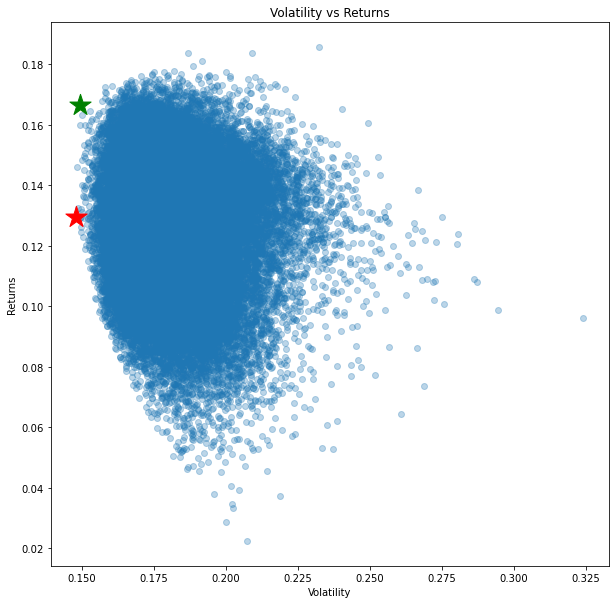

In [17]:
fig, ax = plt.subplots(figsize=(10, 10))
plt.scatter(data=weights, x='Volatility', y='Returns', marker='o',alpha=0.3)
plt.scatter(max_sharpe_point[1],max_sharpe_point[0], color='g', marker='*', s=500)
plt.scatter(min_vol_point[1],min_vol_point[0], color='r', marker='*', s=500)
ax.set_title(f"Volatility vs Returns")
ax.set_xlabel(f"Volatility")
ax.set_ylabel(f"Returns")
fig.show()

In [18]:
test_df=yf.download(stocks,start='2017-04-01',end='2019-03-31',progress=False)['Adj Close']
test_df.sort_index(inplace=True)
test_df.head()

,CIPLA.NS,HDFCBANK.NS,ITC.NS,TATAMOTORS.NS,TITAN.NS,ULTRACEMCO.NS
Date,,,,,,
2017-04-03,579.595398,690.371826,230.533981,470.399994,446.533630,3963.961670
2017-04-05,579.986511,689.962463,228.405167,473.500000,478.029633,4017.611572
2017-04-06,577.297058,692.924988,224.433914,473.200012,473.800934,4047.045166
2017-04-07,577.003601,693.093445,223.246658,468.299988,471.856781,4017.365479
2017-04-10,576.661377,690.829468,223.983582,474.899994,472.197052,3995.610107


In [19]:
test_returns=test_df.resample('Y').last().pct_change().mean()
test_volatility=test_df.pct_change().apply(lambda x: np.log(1+x)).std().apply(lambda x: x*np.sqrt(250))
test_cov_matrix=test_df.pct_change().apply(lambda x: np.log(1+x)).cov()
test_weights=[max_sharpe_point[2],max_sharpe_point[3],max_sharpe_point[4],max_sharpe_point[5],max_sharpe_point[6],max_sharpe_point[7]]
test_weights=np.array(test_weights)
test_weights

array([0.00666793, 0.56488386, 0.17401561, 0.00641268, 0.14270308,
       0.10531683])

In [20]:
test_portfolio_return = np.sum(test_returns * test_weights)
var = test_cov_matrix.mul(test_weights, axis=0).mul(test_weights, axis=1).sum().sum()
sd = np.sqrt(var)
ann_sd = sd*np.sqrt(250)
test_portfolio_std_dev = ann_sd
print('test return is '+str(test_portfolio_return))
print('test std dev is '+str(test_portfolio_std_dev))   

test return is 0.09189173778778419
test std dev is 0.12694196804460042


In [21]:
test_weights=[min_vol_point[2],min_vol_point[3],min_vol_point[4],min_vol_point[5],min_vol_point[6],min_vol_point[7]]
test_weights=np.array(test_weights)
test_weights

array([0.17202966, 0.52077977, 0.19729946, 0.00338654, 0.08921438,
       0.01729018])

In [22]:
test_portfolio_return = np.sum(test_returns * test_weights)
var = test_cov_matrix.mul(test_weights, axis=0).mul(test_weights, axis=1).sum().sum()
sd = np.sqrt(var)
ann_sd = sd*np.sqrt(250)
test_portfolio_std_dev = ann_sd
print('test return is '+str(test_portfolio_return))
print('test std dev is '+str(test_portfolio_std_dev))  

test return is 0.07478767638769694
test std dev is 0.12419132879664951
